### Generating data with the desired time-frequency properties

We can simulate EEG-like data using the methods in **util.simulate_data**, this data can be used to test different methods.

In [1]:
import sys
sys.path.insert(1, '..')

import time
import scipy
import h5py
import numpy                 as     np
import xarray                as     xr
import pandas                as     pd
import matplotlib.pyplot     as     plt
from   tqdm                  import tqdm
from   conn.conn_tf          import _tf_decomp
from   conn.conn_spec        import conn_spec
from   util.simulate_data    import *

#### Function to visualize the data

In [2]:
def plot_data(data_array, chan, fs, n):
    assert type(data_array)==xr.core.dataarray.DataArray, 'Data should be an xarray'
    plt.subplot2grid( (3,3), (0,0), colspan=3 )
    for i in range(data_array.shape[0]):
        plt.plot(data_array.time.values, data_array[i,chan,:], color='b', lw=.2)
    plt.plot(data_array.time.values, data_array[:,chan,:].mean(dim='trials'), color = 'r', lw=3)
    plt.xlim([data_array.time.values.min(), data_array.time.values.max()])
    plt.ylabel('Amplitude', fontsize=12)
    plt.xlabel('Time (s)', fontsize=12)
    plt.subplot2grid( (3,3), (1,0) )
    plt.hist(data_array[:,:,:].values.flatten(), 50)
    plt.ylabel('#', fontsize=12)
    plt.xlabel('Amplitude', fontsize=12)    
    plt.subplot2grid( (3,3), (1,1), colspan=2 )
    data_fft = np.fft.fft( data_array[:,chan,:].values, axis = -1)
    s = np.abs(data_fft) / n
    s[1:] = 2*s[1:]
    f = np.linspace(0,fs/2,n//2)
    plt.plot(f, s.real.mean(axis=0)[:n//2])
    plt.xlim([0,f.max()])
    plt.ylabel('Periodogram', fontsize=12)
    plt.xlabel('Freq (Hz)', fontsize=12)
    plt.subplot2grid( (3,3), (2,0), colspan=3 )
    W = _tf_decomp(data_array.values, fs, np.linspace(5,f.max(),100), mode='morlet', n_cycles=6.0,
                   decim=1, kw_cwt={}, kw_mt={}, n_jobs=20)
    S = np.squeeze( W * np.conj(W) ).real
    plt.imshow(S.mean(axis=0), aspect='auto', cmap='jet', origin='lower', 
           extent=[data_array.time.min(),data_array.time.max(),f[0],f[-1]])
    plt.ylabel('Freq (Hz)', fontsize=12)
    plt.xlabel('Time (s)', fontsize=12)
    plt.tight_layout()

### 1. White noise

White noise can be drawn either from uniform or normal distributions

#### Uniform

In [3]:
signal = white_noise(trials=10, nvars=1, n=1000, fs=250, amp=1, ntype='uniform')

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    2.3s finished


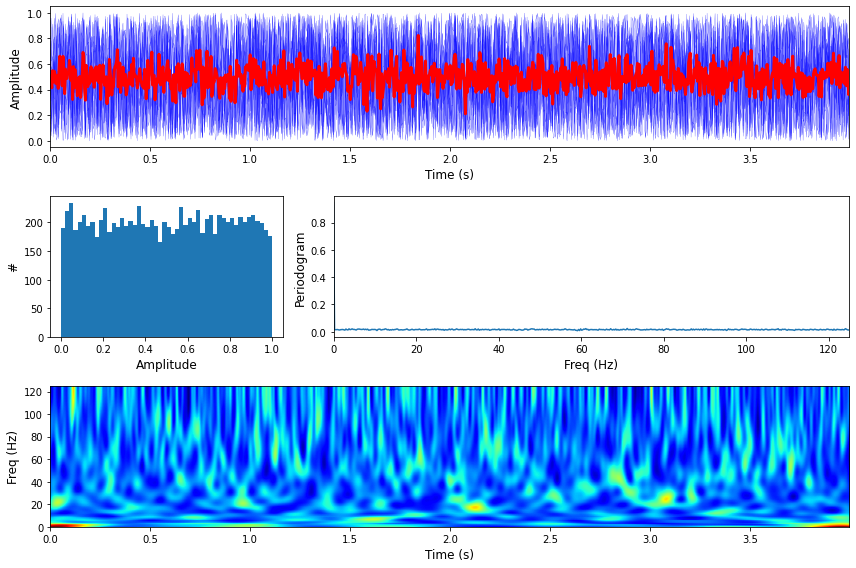

In [4]:
plt.figure(figsize=(12,8))
plot_data(signal, 0,250,1000)

#### Normal

In [5]:
signal = white_noise(trials=10, nvars=1, n=1000, fs=250, amp=1, ntype='normal')

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.6s finished


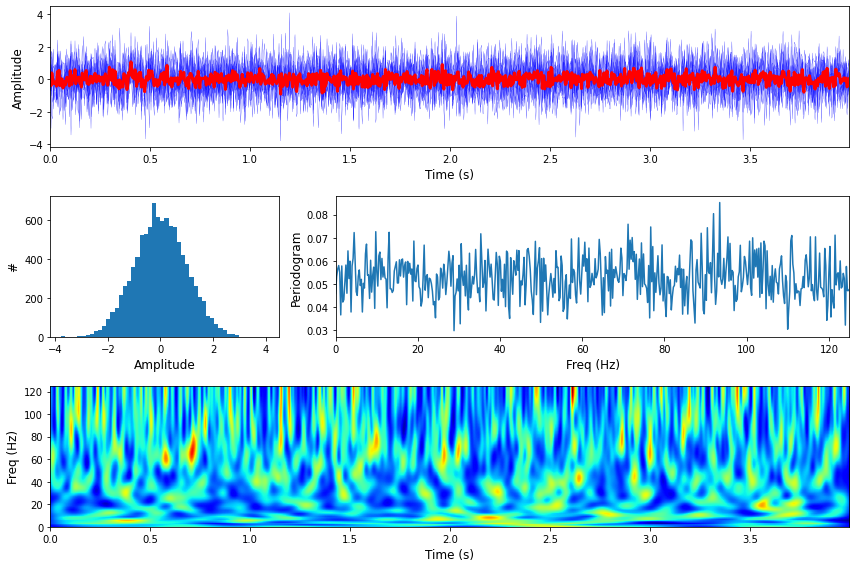

In [6]:
plt.figure(figsize=(12,8))
plot_data(signal, 0,250,1000)

### 2. Pink noise

In [7]:
signal = pink_noise(trials=10, nvars=1, n=1000, fs=250, tau=50)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.6s finished


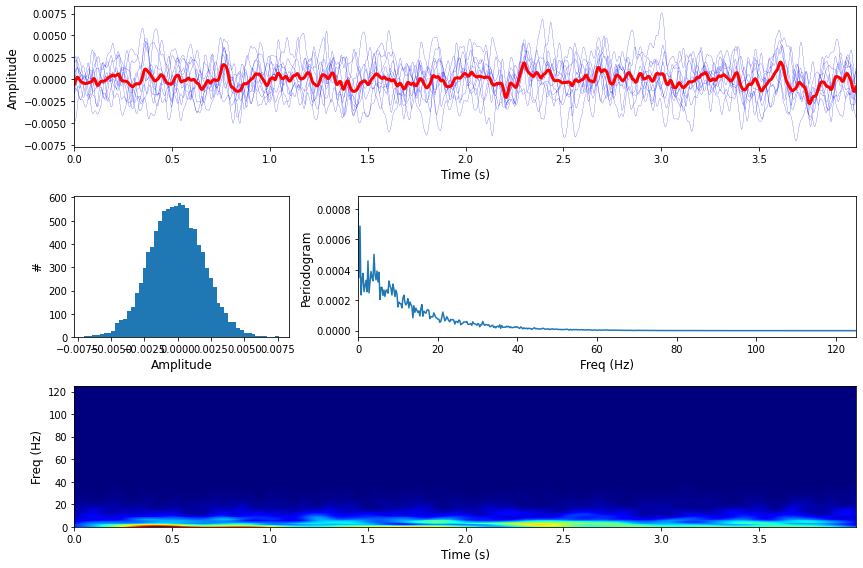

In [8]:
plt.figure(figsize=(12,8))
plot_data(signal, 0,250,1000)

### 3. Ongoing non-stationary signal

In [9]:
signal = ongoing_non_stationary(trials=10, nvars=1, n=1000, fs=250, 
                                peakfreq=np.array([10, 60]), 
                                fwhm=np.array([10, 10]))

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.7s finished


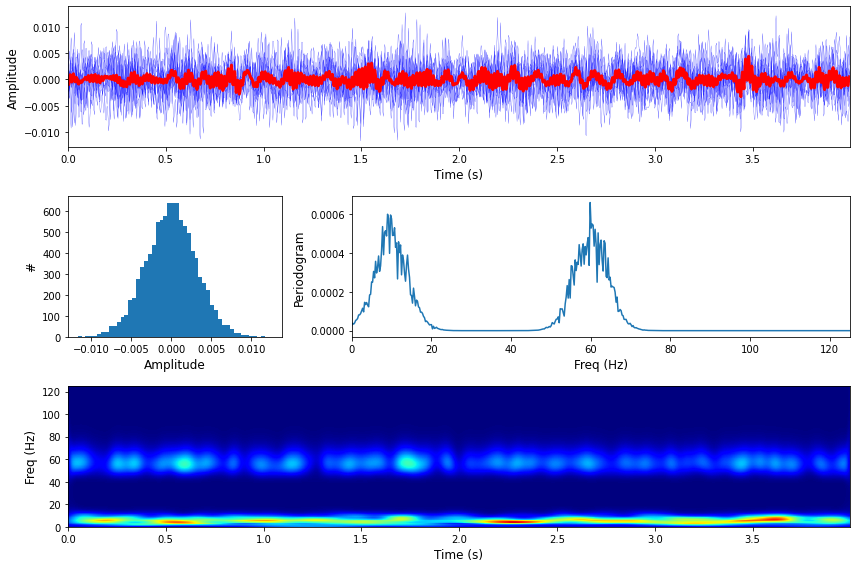

In [10]:
plt.figure(figsize=(12,8))
plot_data(signal, 0,250,1000)

### 4. Transient oscillation with Gaussian

In [11]:
signal = transient_oscillation_gauss(trials=10, nvars=1, n=1000, fs=250, sin_freq=50, 
                                      peaktime=np.array([1,3]), width=np.array([.2,.2]), 
                                      phaselocked=False)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.8s finished


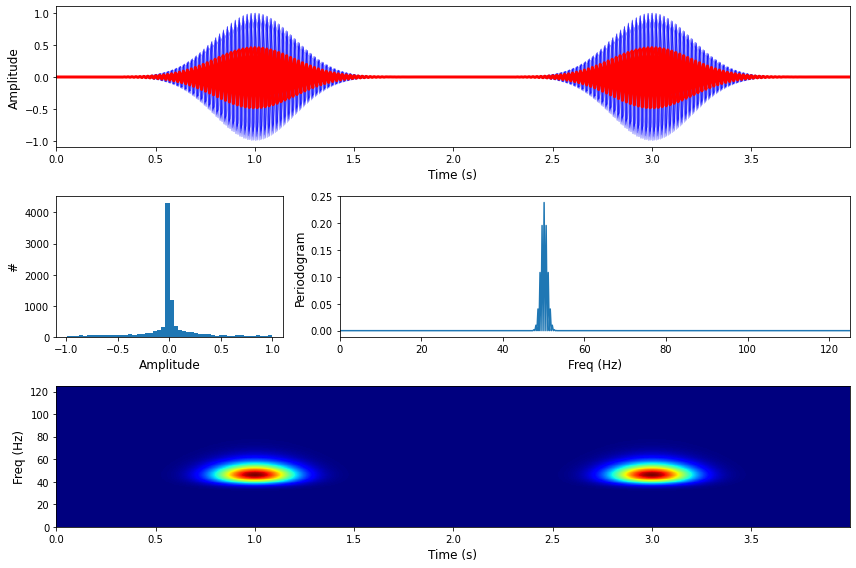

In [12]:
plt.figure(figsize=(12,8))
plot_data(signal, 0,250,1000)

### 5. Transcient non-stationary  signal

In [13]:
signal = transient_oscillation_gauss_non_stationary(trials=10, nvars=1, n=200, fs=60, 
                                                    peakfreq=np.array([21]), fwhm=np.array([5]), 
                                                    peaktime=np.array([1]), width=np.array([0.2]))

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.6s finished


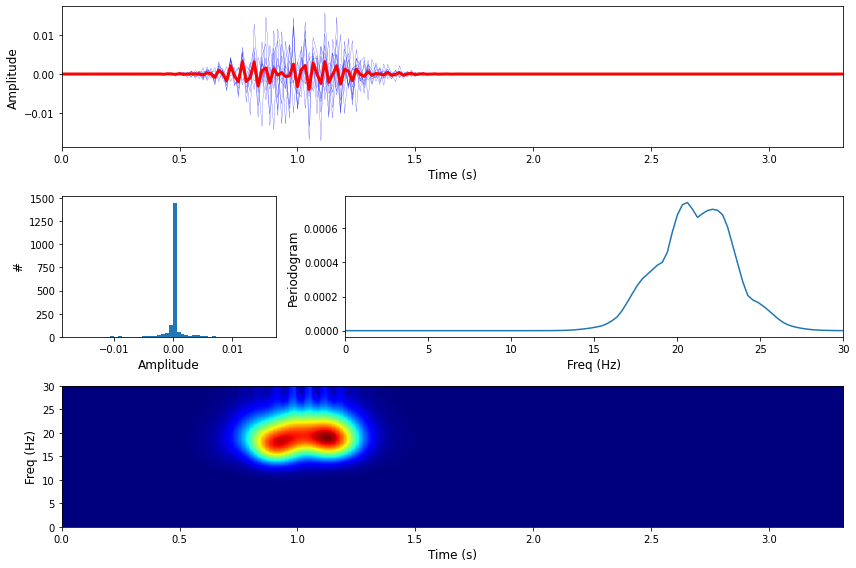

In [14]:
plt.figure(figsize=(12,8))
plot_data(signal,0,60,200)

### Testing the coherence metric in the simulated data

First, let's create two signal with localized burts. The first signal with a burst at $1$ s and $3$ s, and the second with a burst only at $3$ s (both with the same width).

In [41]:
T  = 10         # Time interval
fs = 250       # Sampling frequency
n  = fs*T       # Number of observations

freqs = np.linspace(0.1, 100, 50) # Frequency axis to use on spectral estimation

def gen_signal(T,fs,noise_level=0, seed=0):
    
    trials = 100
    
    np.random.seed(seed)

    x = transient_oscillation_gauss_non_stationary(trials=trials, nvars=1, n=n, fs=fs, 
                                                   peakfreq=np.array([60]), fwhm=np.array([5]), 
                                                   peaktime=np.array([4]), width=np.array([.2]))

    y = transient_oscillation_gauss_non_stationary(trials=trials, nvars=1, n=n, fs=fs, 
                                                   peakfreq=np.array([60]), fwhm=np.array([5]), 
                                                   peaktime=np.array([4, 8]), width=np.array([.2, 0.2]))

    x_noise = pink_noise(trials=trials, nvars=1, n=n, fs=fs, tau=50)
    y_noise = pink_noise(trials=trials, nvars=1, n=n, fs=fs, tau=50) 

    signal = xr.DataArray(np.zeros([100,2,n]), dims=("trials", "roi", "times"),
                          coords = {"times": x.time.values})
    signal[:,0,:] = np.squeeze( 10*x.values + noise_level*x_noise.values )
    signal[:,1,:] = np.squeeze( 10*y.values + noise_level*y_noise.values )
    
    return signal

In [108]:
# Signal with pink noise
s = gen_signal(T,fs,noise_level=5, seed=10) 

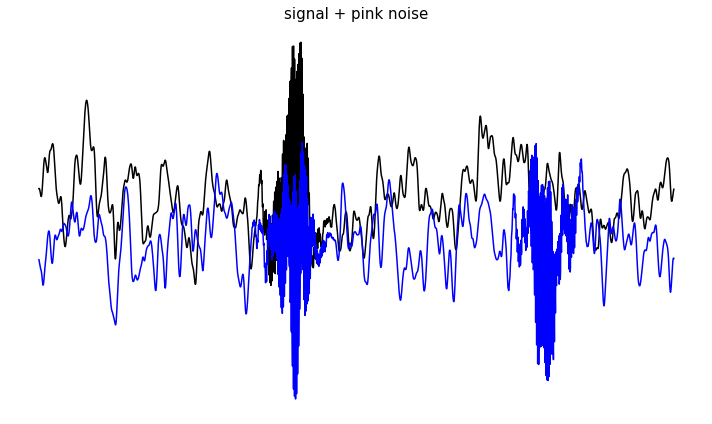

In [109]:
# Plotting ERP of each signal
plt.figure(figsize=(10,6))
plt.plot(s.times, np.squeeze(s.mean(dim="trials")).sel(roi=0), 'k')
plt.plot(s.times, np.squeeze(s.mean(dim="trials")).sel(roi=1)-.0005, 'b')
#plt.legend(['x', 'y'], fontsize=15)
plt.axis('off')
plt.title('signal + pink noise', fontsize=15)
plt.tight_layout()

In [129]:
start = time.time()

coh = []

for mode in ["morlet", "multitaper"]:

    # define temporal windows + compute the DFC
    n_cycles = freqs/4.

    kw = dict(
        freqs=freqs, times="times", roi=None, foi=None, n_jobs=-1,
        mode=mode, n_cycles=n_cycles, decim=10, metric="coh", sm_kernel="square",
        sm_times=.3, sm_freqs=1, block_size=1
    )

    # compute the coherence
    coh += [conn_spec(s, **kw)]

end = time.time()

coh = xr.concat(coh, dim="mode")

print('Elapsed time to load super-tensor: ' +str((end - start)) + ' sec.' )

WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=50, decim=10, sm_times=8, sm_freqs=1)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.2s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=50, decim=10, sm_times=8, sm_freqs=1)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.7s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

Elapsed time to load super-tensor: 7.660068035125732 sec.


In [130]:
coh = coh.squeeze(dim='roi')

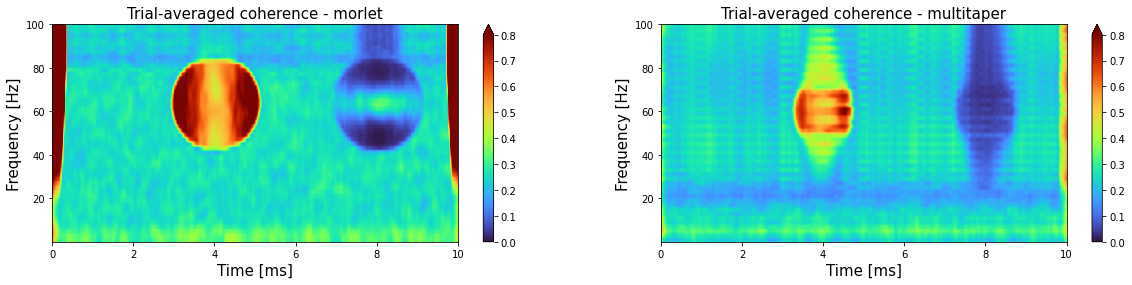

In [131]:
modes = ["morlet", "multitaper"]

plt.figure(figsize=(20,4))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow( coh.sel(mode=i).mean("trials"), aspect='auto', cmap='turbo', origin='lower',
               extent=[0,T,freqs[0],freqs[-1]], vmin=0, vmax=.8); plt.colorbar(extend="max")
    plt.ylabel('Frequency [Hz]', fontsize=15)
    plt.xlabel('Time [ms]', fontsize=15)
    plt.title(f"Trial-averaged coherence - {modes[i]}", fontsize=15);

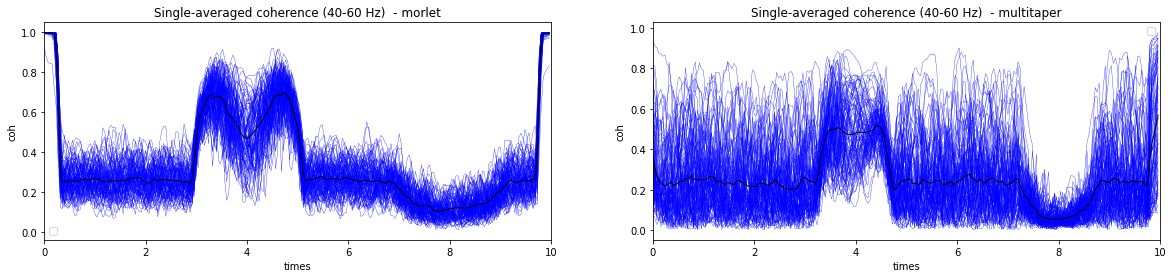

In [132]:
plt.figure(figsize=(20,4))
for i in range(2):
    plt.subplot(1,2,i+1)
    coh.sel(mode=i, freqs=slice(40,80)).mean("freqs").plot(x="times", hue="trials", color="b", lw=.3);
    coh.sel(mode=i, freqs=slice(40,80)).mean("freqs").mean("trials").plot(x="times", hue="trials", color="k", lw=1);
    plt.title(f"Single-averaged coherence (40-60 Hz)  - {modes[i]}")
    plt.xlim(0,10)
    plt.legend([])